# 4. Learning Curves

This notebook focuses on generating and visualizing learning curves for machine learning models. Learning curves provide insights into the relationship between training set size and model performance, helping to assess if a model would benefit from more training data or if it is suffering from high variance or bias.

#### Packages and Data

The notebook begins by importing necessary packages, including NumPy, pandas, matplotlib, and machine learning models such as `XGBClassifier` and `LogisticRegression`. The `train_test_split` function from scikit-learn is imported for splitting the data into training and test sets, and the `KNNImputer` is imported for imputing missing values. Additionally, the `%matplotlib inline` magic command is used to display matplotlib plots inline.

Next, the data is loaded into a pandas DataFrame from a specified directory. Various preprocessing steps are performed on the data, such as converting data types and handling missing values.

#### Plotting Learning Curves

The `plot_learning_curve` function is defined to generate the learning curve for a given model using different training set sizes. It takes as input the features (`X`), the target variable (`y`), and the model to be trained and evaluated. The function returns the learning curve plot.

The function loops over a range of training set sizes, randomly selecting subsets of the data for each size. The model is trained on each subset, and the accuracy on the test set is calculated and recorded. The learning curve plot is generated by plotting the training set size against the test set accuracy. Additionally, a moving average of the accuracy values is calculated and plotted to provide a smoother representation of the learning curve.

#### Model Evaluation

The notebook proceeds to evaluate the learning curves for different models and feature sets.

First, a logistic regression model is evaluated using the start glucose and duration features. The model is trained and assessed using the `plot_learning_curve` function, and the learning curve plot is displayed.

Next, an XGBoost model is evaluated using a selected subset of features. The features are loaded from a file, and the model is trained and assessed using the `plot_learning_curve` function. The learning curve plot is displayed.

Finally, the XGBoost model is evaluated using all available features. The data is preprocessed, the model is trained and assessed using the `plot_learning_curve` function, and the learning curve plot is displayed.

This notebook provides a step-by-step guide to generate and interpret learning curves, allowing for the assessment of model performance and the determination of the optimal training set size.

In [1]:
import numpy as np
import pandas as pd
# Import machine learning methods
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:

def plot_learning_curve(X, y, strat, model, ax):
    """
    Plots the learning curve for a given model using different training set sizes and Stratified K-Fold.

    Args:
        X (pd.DataFrame): The input features.
        y (pd.Series): The target variable.
        model: The machine learning model to be trained and evaluated.
        ax: The axis object to plot on.
        strat (pd.Series): The stratification column.

    Returns:
        ax: The axis object with the learning curve plot.
    """
    test_fraction = 0.20  # Use 25% of data for testing
    data_rows = X.shape[0]
    max_training_size = int(data_rows * (1 - test_fraction))
    
    X_np = X.values
    y_np = y.values

    # Define the Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    results_training_size = []
    results_accuracy = []

    for train_size in range(100, max_training_size, 100):
        fold_accuracies = []

        for train_index, test_index in skf.split(X, strat):
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y_np[train_index], y_np[test_index]

            # Reduce training set size
            selection_index = np.random.choice(train_index, train_size, replace=False)
            X_train = X.iloc[selection_index]
            y_train = y.iloc[selection_index]

            # Fit model and predict
            model.fit(X_train, y_train)
            y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

            # Calculate ROC AUC score
            roc_score = roc_auc_score(y_test, y_pred_prob)
            fold_accuracies.append(roc_score)

        # Average accuracy over all folds
        results_accuracy.append(np.mean(fold_accuracies))
        results_training_size.append(train_size)

    # Calculate moving average
    moving_average = np.convolve(results_accuracy, np.ones((5,))/5, mode='valid')
    x_moving_average = results_training_size[2:-2]

    ax.scatter(results_training_size, results_accuracy, label='ROC AUC')
    ax.plot(x_moving_average, moving_average, label='Moving average', color='orange', linewidth=3)
    ax.set_xlabel('Training set size')
    ax.set_ylabel('Test set ROC AUC')
    ax.grid(True)
    ax.legend(loc='best')

    return ax


## 1.1. Start glucose, duration and logistic regression

In [3]:
directory = '../../data/tidy_data/final_df/'
# Read data
df = pd.read_csv(directory + 'df.csv')
strat = df['stratify'] 
X = pd.read_csv(directory + 'X.csv')
y = df['y'] 

## Selected features with XGBoost

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12, 17))

In [6]:
print("Shape of X_train:", X.shape)
print("Shape of y_train:", y.shape)
print(strat.shape)

Shape of X_train: (16490, 414)
Shape of y_train: (16490,)
(16490,)


In [ ]:
%%capture
model1 = XGBClassifier()
ax[0] = plot_learning_curve(X, y, strat, model1, ax[0])

X_simp = X[['start_glc', 'duration']]
model2 = XGBClassifier()
ax[1] = plot_learning_curve(X_simp, y, strat, model2, ax[1])

In [ ]:
ax[0].text(-0.08, 1.02, 'A', transform=ax[0].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=18)
ax[1].text(-0.08, 1.02, 'B', transform=ax[1].transAxes, fontweight="bold", va="bottom", ha="left", fontsize=18)

Text(-0.08, 1.02, 'B')

In [ ]:
ax[0].legend(loc='upper left', bbox_to_anchor=(0.9, 1.1))

In [ ]:
fig.savefig('../../results/figs/suppl_fig_learning_curves.pdf', bbox_inches='tight')

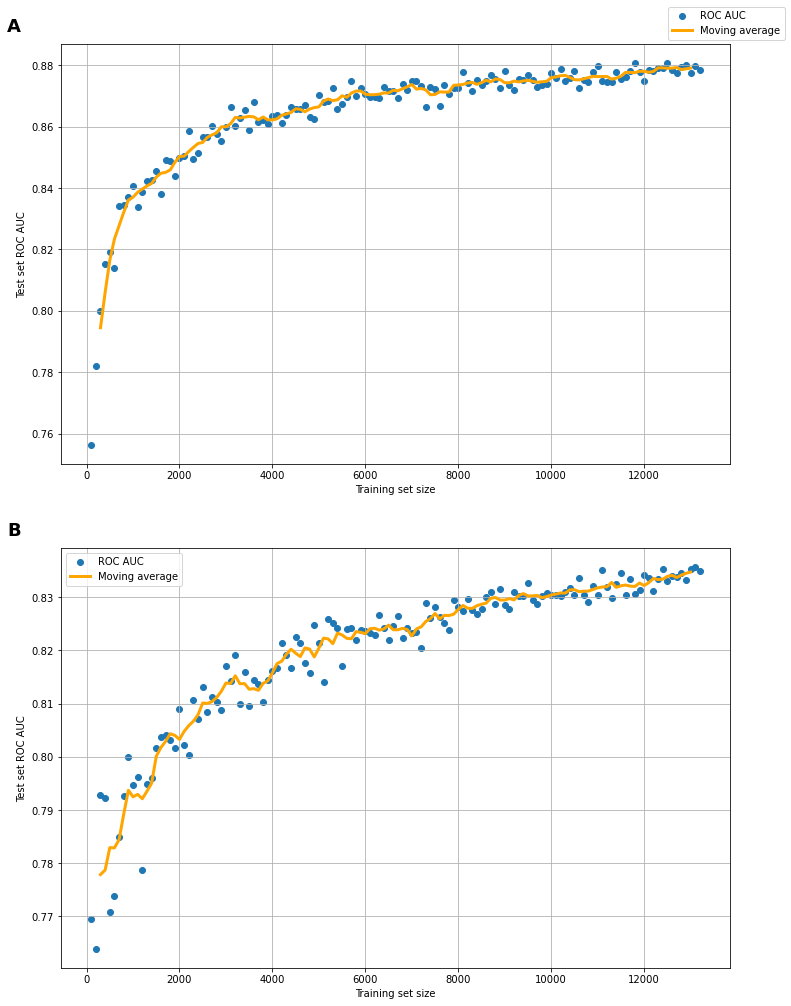

In [ ]:
fig